In [7]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
#plt.style.use('ggplot')
%precision 4
#np.set_printoptions(suppress=True)

'%.4f'

1\. **Maximum wind speed prediction at the Sprogø station**

The exercise goal is to predict the maximum wind speed occurring every 50 years even if no measure exists for such a period. The available data are only measured over 21 years at the Sprogø meteorological station located in Denmark. 

The annual maxima are supposed to fit a normal probability density function. However such function is not going to be estimated because it gives a probability from a wind speed maxima. Finding the maximum wind speed occurring every 50 years requires the opposite approach, the result needs to be found from a defined probability. That is the quantile function role and the exercise goal will be to find it. In the current model, it is supposed that the maximum wind speed occurring every 50 years is defined as the upper 2% quantile.

By definition, the quantile function is the inverse of the cumulative distribution function. The latter describes the probability distribution of an annual maxima. In the exercise, the cumulative probability $p_i$ for a given year i is defined as $p_i = i/(N+1)$ with $N = 21$, the number of measured years. Thus it will be possible to calculate the cumulative probability of every measured wind speed maxima. From those experimental points, the scipy.interpolate module will be very useful for fitting the quantile function. Finally the 50 years maxima is going to be evaluated from the cumulative probability of the 2% quantile.

Practically, load the dataset:

```python
import numpy as np
max_speeds = np.load('max-speeds.npy')
years_nb = max_speeds.shape[0]
```

Compute then the cumulative probability $p_i$ (`cprob`) and sort the maximum speeds from the data. Use then the  UnivariateSpline from scipy.interpolate to define a quantile function and thus estimate the probabilities.

In the current model, the maximum wind speed occurring every 50 years is defined as the upper 2% quantile. As a result, the cumulative probability value will be:

```python
fifty_prob = 1. - 0.02
```

So the storm wind speed occurring every 50 years can be guessed as:

``` python
fifty_wind = quantile_func(fifty_prob)
```



In [8]:
#load the dataset
max_speeds = np.load('max-speeds.npy')
years_nb = max_speeds.shape[0]
fifty_prob = 1. - 0.02
N=years_nb

#function to calculate the cumulative probability 𝑝𝑖  for a given year i 
p = lambda i : i/(N+1)

# array of the cumulative probabilities 𝑝𝑖
P=np.array([p(i) for i in range(1,N+1)])
print("the cumulative probabilities 𝑝𝑖 :\n",P)

the cumulative probabilities 𝑝𝑖 :
 [0.0455 0.0909 0.1364 0.1818 0.2273 0.2727 0.3182 0.3636 0.4091 0.4545
 0.5    0.5455 0.5909 0.6364 0.6818 0.7273 0.7727 0.8182 0.8636 0.9091
 0.9545]


 max_speeds sorted : 
 [32.97 30.19 29.75 28.79 28.09 27.93 26.76 26.75 26.73 26.68 26.65 26.65
 26.37 26.19 25.79 25.28 24.16 23.85 23.34 23.2  22.46]


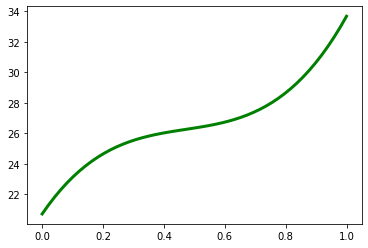

In [20]:
#sort the maximum speeds from the data
max_speeds.sort()
max_speeds_sort = max_speeds[::-1]
print(" max_speeds sorted : \n",max_speeds_sort)

from scipy.interpolate import UnivariateSpline

spl= UnivariateSpline(P,max_speeds )
xs = np.linspace(0, 1, 50)
plt.plot(xs, spl(xs), 'g', lw=3)

In [18]:
# guess the storm wind speed occurring every 50 years
fifty_wind = spl(fifty_prob)
print("fifty_wind : ",fifty_wind)

fifty_wind :  32.97989844019469


2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18

min: -62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58

* Plot these temperature extremes.
* Define a function that can describe min and max temperatures. 
* Fit this function to the data with scipy.optimize.curve_fit().
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

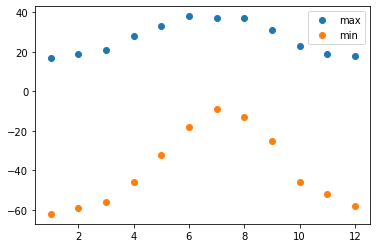

In [6]:
# plot the temperatures

maxt = np.array([17, 19, 21, 28, 33, 38, 37, 37, 31, 23, 19, 18])
mint = np.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])
months = np.linspace(1, 12, 12)
plt.plot(months, maxt,'o', label='max')
plt.plot(months, mint,'o', label='min')
plt.legend()


In [56]:
from scipy import asarray as ar,exp 

# define a gaussian function
def f(x,a, m, std):
    return a*exp(-(x-m)**2/(2*std**2))

# the default parameters for the max temperature gaussian
mean = sum(months*maxt)/12    
sigma = sum(maxt*(months-mean)**2)/12 

# find the best parameters of the gaussian for the max values
from scipy import optimize 
params_max, params_covariance_max = optimize.curve_fit(f, months, maxt, p0=[1,mean, sigma])
print(params_max)

# the default parameters for the min temperature gaussian
mean = sum(months*mint)/12    
sigma = sum(mint*(months-mean)**2)/12 

# find the best parameters of the gaussian for the min values
params_min, params_covariance_min = optimize.curve_fit(f, months, mint, p0=[1,mean, sigma])
print(params_min)

[ 2.6750e+01 -8.2709e+10  1.5614e+14]
[-3.9667e+01 -3.4572e+11 -9.3700e+15]


<ipython-input-56-7152978de765>:20: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
  return a*exp(-(x-m)**2/(2*std**2))


<ipython-input-56-7152978de765>:20: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
  return a*exp(-(x-m)**2/(2*std**2))
<ipython-input-56-7152978de765>:20: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
  return a*exp(-(x-m)**2/(2*std**2))


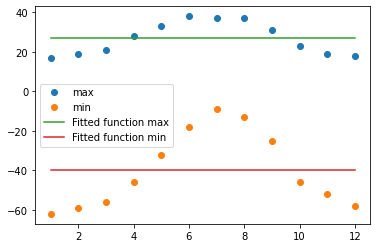

In [57]:
# display the dataset of temperatures
plt.plot(months, maxt,'o', label='max')
plt.plot(months, mint,'o', label='min')

# display the function founded
plt.plot(months, f(months, params_max[0], params_max[1],params_max[2]),label='Fitted function max')
plt.plot(months, f(months, params_min[0], params_min[1],params_min[2]),label='Fitted function min')


plt.legend(loc='best')


In [58]:
#The result is not good, maybe we have this result because this function has 0 in average loss (without absolute value of loss). 
# The offset between the min and the max temperature is the same.

3\. **2D minimization of a six-hump camelback function**

$$
f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2
$$

has multiple global and local minima. Find the global minima of this function.

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use numpy.meshgrid() and pylab.imshow() to find visually the regions.
* Use scipy.optimize.minimize(), optionally trying out several of its methods.

How many global minima are there, and what is the function value at those points? What happens for an initial guess of $(x, y) = (0, 0)$ ?


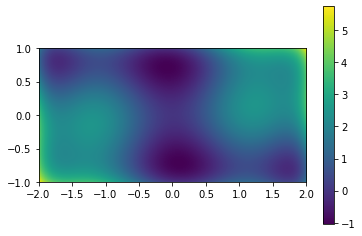

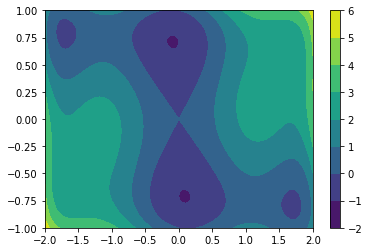

minimum result when initial guess is (-0.1,0.75) :  [-0.0898  0.7127]
f( [-0.0898  0.7127] ) =  -1.0316284534898765

minimum result when initial guess is (0.1,-0.75) :  [ 0.0898 -0.7127]
f( [ 0.0898 -0.7127] ) =  -1.0316284534898765

minimum result when initial guess is (0,0) :  [0. 0.]
f( [0. 0.] ) =  0.0


In [133]:
# six-hump camelback function
def f(x,y):
    return (4-2.1*x**2 + ((x**4)/3))*x**2 + x*y + (4*y**2 - 4)*y**2

x = np.linspace(-2,2,1000)
y= np.linspace(-1,1,1000)

# meshgrid
xx, yy = np.meshgrid(x, y, sparse=True)
z = f(xx,yy)

# pylab.imshow() 
import matplotlib.cm as cm
im = plt.imshow(z, interpolation='none',origin='lower', extent=[-2,2, -1, 1])
plt.colorbar()
plt.show()

#contourf
h = plt.contourf(x,y,z)
plt.colorbar()
plt.show()

#the 2 global minima are for (x=-0.1, y=0.75)  and (x=0.1, y=-0.75)

from scipy.optimize import minimize
def fbis(x):
    y=x[1]
    x= x[0]
    return (4-2.1*x**2 + ((x**4)/3))*x**2 + x*y + (4*y**2 - 4)*y**2


# find the global minima

res =minimize(fbis,[-0.1,0.75]) 
print("minimum result when initial guess is (-0.1,0.75) : ",res.x)
print("f(",res.x,") = ",fbis(res.x))

res =minimize(fbis,[0.1,-0.75]) 
print("\nminimum result when initial guess is (0.1,-0.75) : ",res.x)
print("f(",res.x,") = ",fbis(res.x))

# if the guess is (0,0), we find one of the local minimum but not the global
res =minimize(fbis,[0.0,0.0]) 
print("\nminimum result when initial guess is (0,0) : ",res.x)
print("f(",res.x,") = ",fbis(res.x))

4\. **FFT of a simple dataset**

Performe a periodicity analysis on the lynxs-hares population

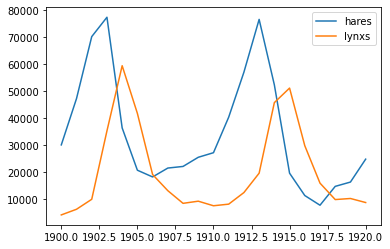

In [148]:
# load the data
data = np.loadtxt("./populations.txt") # load the data of the text file
import pandas as pd
dt=pd.DataFrame(data)
hares = dt[1].values
years = dt[0].values
lynxs = dt[2].values
plt.plot(years, hares, label='hares')
plt.plot(years, lynxs, label='lynxs')
plt.legend()



C:\Users\ophel\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


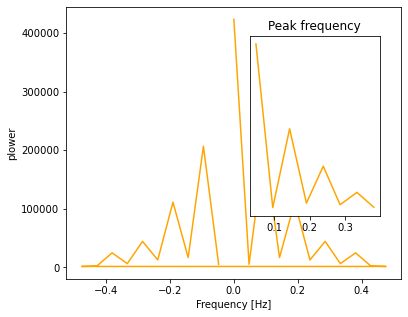

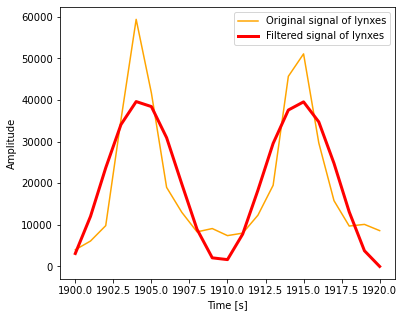

In [149]:
from scipy import fftpack
# The FFT of the signal
sig_fft = fftpack.fft(lynxs)

# And the power (sig_fft is of complex dtype)
power = np.abs(sig_fft)

# The corresponding frequencies
sample_freq = fftpack.fftfreq(lynxs.size, d=1)

# Plot the FFT power
plt.figure(figsize=(6, 5))
plt.plot(sample_freq, power, color='orange')
plt.xlabel('Frequency [Hz]')
plt.ylabel('plower')

# Find the peak frequency: we can focus on only the positive frequencies
pos_mask = np.where(sample_freq > 0)
freqs = sample_freq[pos_mask]
peak_freq = freqs[power[pos_mask].argmax()]

# An inner plot to show the peak frequency
axes = plt.axes([0.55, 0.3, 0.3, 0.5])
plt.title('Peak frequency')
plt.plot(freqs[:8], power[:8], color='orange')
plt.setp(axes, yticks=[])


high_freq_fft = sig_fft.copy()
high_freq_fft[np.abs(sample_freq) > peak_freq] = 0
filtered_sig = fftpack.ifft(high_freq_fft)

plt.figure(figsize=(6, 5))
plt.plot(years, lynxs, color ='orange', label='Original signal of lynxes')
plt.plot(years, filtered_sig, linewidth=3, color='red', label='Filtered signal of lynxes')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.legend(loc='best')


#### the periodicity = 10 years

C:\Users\ophel\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


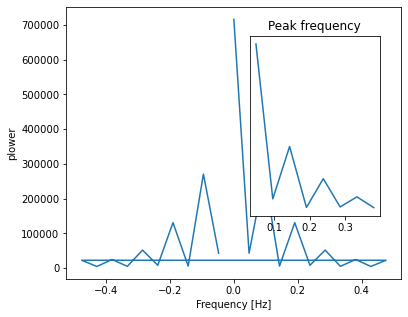

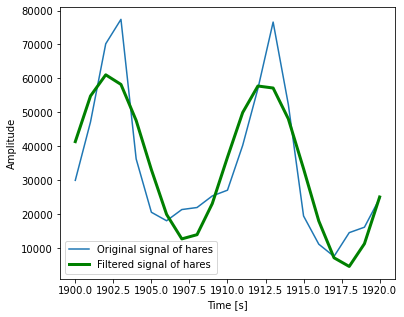

In [150]:
# The FFT of the signal
sig_fft = fftpack.fft(hares)

# And the power (sig_fft is of complex dtype)
power = np.abs(sig_fft)

# The corresponding frequencies
sample_freq = fftpack.fftfreq(hares.size, d=1)

# Plot the FFT power
plt.figure(figsize=(6, 5))
plt.plot(sample_freq, power)
plt.xlabel('Frequency [Hz]')
plt.ylabel('plower')

# Find the peak frequency: we can focus on only the positive frequencies
pos_mask = np.where(sample_freq > 0)
freqs = sample_freq[pos_mask]
peak_freq = freqs[power[pos_mask].argmax()]

# An inner plot to show the peak frequency
axes = plt.axes([0.55, 0.3, 0.3, 0.5])
plt.title('Peak frequency')
plt.plot(freqs[:8], power[:8])
plt.setp(axes, yticks=[])


high_freq_fft = sig_fft.copy()
high_freq_fft[np.abs(sample_freq) > peak_freq] = 0
filtered_sig = fftpack.ifft(high_freq_fft)

plt.figure(figsize=(6, 5))
plt.plot(years, hares, label='Original signal of hares')
plt.plot(years, filtered_sig, linewidth=3, color='green', label='Filtered signal of hares')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.legend(loc='best')

#### the periodicity = 10 years

5\. **FFT of an image**

* Examine the provided image `moonlanding.png`, which is heavily contaminated with periodic noise. In this exercise, we aim to clean up the noise using the Fast Fourier Transform.
* Load the image using pylab.imread().
* Find and use the 2-D FFT function in scipy.fftpack, and plot the spectrum (Fourier transform of) the image. Do you have any trouble visualising the spectrum? If so, why?
* The spectrum consists of high and low frequency components. The noise is contained in the high-frequency part of the spectrum, so set some of those components to zero (use array slicing).
* Apply the inverse Fourier transform to see the resulting image.

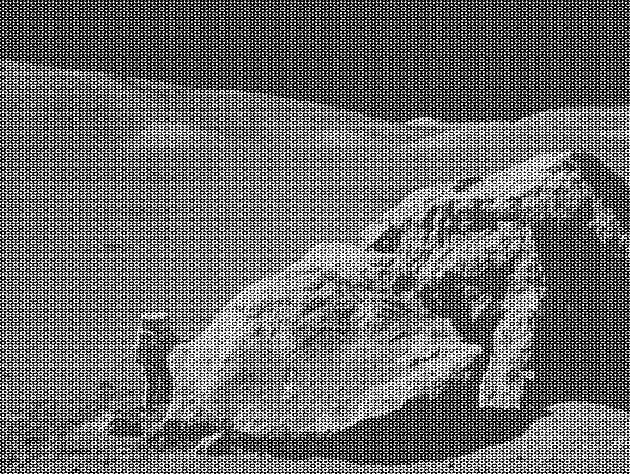

In [110]:
from IPython.display import Image
Image("moonlanding.png")

Text(0.5, 1.0, 'Resulting image')

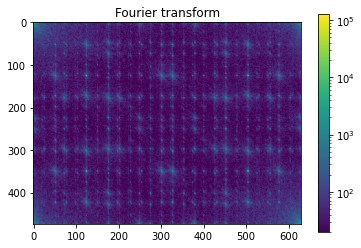

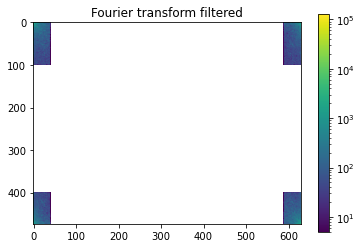

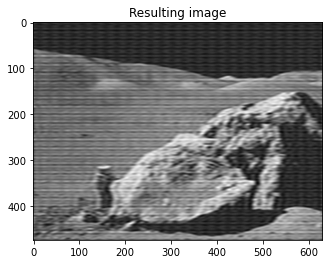

In [147]:
# load the image
im = plt.imread("moonlanding.png")

# use the 2D fft
im_fft = fftpack.fft2(im)
power = np.abs(im_fft)  #because it is complex

#diplay the fourier transform
from matplotlib.colors import LogNorm
plt.imshow(power, norm=LogNorm(vmin=20))
plt.colorbar()
plt.title('Fourier transform')

# put the high values of frequeces at 0
high_freq_fft = im_fft.copy()
#Rows
high_freq_fft[100:400] = 0
#Columns
high_freq_fft[:, 40:590] = 0

# display the new fourier transform
plt.figure()
plt.imshow(np.abs(high_freq_fft), norm=LogNorm(vmin=5))
plt.colorbar()
plt.title('Fourier transform filtered')

# Apply the inverse Fourier transform 
plt.figure()
im_2 = fftpack.ifft2(high_freq_fft).real
plt.imshow(im_2,plt.cm.gray)
plt.title("Resulting image")
